In [10]:
if 'google.colab' in str(get_ipython()):
  # install packages needed for this task
  !pip install tensorflow==2.3.1
  !pip install tensorflow_quantum==0.4.0
  !pip install quple==0.6.9

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320.4 MB 27 kB/s 
     |████████████████████████████████| 2.9 MB 38.6 MB/s 
     |████████████████████████████████| 459 kB 64.6 MB/s 
     |████████████████████████████████| 20.1 MB 1.2 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.9 MB 25.6 MB/s 
     |████████████████████████████████| 1.6 MB 41.7 MB/s 
     |████████████████████████████████| 5.6 MB 28.3 MB/s 
     |████████████████████████████████| 1.3 MB 40.1 MB/s 
     |████████████████████████████████| 211 kB 42.3 MB/s 
     |████████████████████████████████| 211 kB 49.0 MB/s 
     |████████████████████████████████| 241 kB 48.9 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
  Attempting uninstall: googleapis-common-protos
    Found existing installation: googleapis-common-protos 1.56.2
    Uninstalling googleapis-common-protos-1.56.2:
      Successfully uninstalled googleapis-common-protos-1.56.2
  Attempting uninstall: sympy
    Found existing installation: sympy 1.7.1
    Uninstalling sympy-1.7.1:


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 80 kB 6.8 MB/s 


In [11]:
# load some packages just to start
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np

In [12]:
if 'google.colab' in str(get_ipython()):
  !wget https://gitlab.cern.ch/clcheng/gsoc2021_qml/-/raw/master/data/QIS_EXAM_200Events.npz

--2022-06-29 12:54:24--  https://gitlab.cern.ch/clcheng/gsoc2021_qml/-/raw/master/data/QIS_EXAM_200Events.npz
Resolving gitlab.cern.ch (gitlab.cern.ch)... 188.184.104.112, 188.184.30.144, 188.184.31.136, ...
Connecting to gitlab.cern.ch (gitlab.cern.ch)|188.184.104.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9140 (8.9K) [application/zip]
Saving to: ‘QIS_EXAM_200Events.npz.1’

QIS_EXAM_200Events. 100%[===================>]   8.93K  --.-KB/s    in 0s      

2022-06-29 12:54:25 (127 MB/s) - ‘QIS_EXAM_200Events.npz.1’ saved [9140/9140]



In [13]:
data = dict(np.load('QIS_EXAM_200Events.npz', allow_pickle=True))
x_train_bkg = data['training_input'].item()['0']
x_test_bkg = data['test_input'].item()['0']
x_train_sig = data['training_input'].item()['1']
x_test_sig = data['test_input'].item()['1']
# combine the signal and background samples
x_train = np.concatenate((x_train_sig, x_train_bkg))
y_train = np.concatenate((np.ones(x_train_sig.shape[0]), np.zeros(x_train_bkg.shape[0])))
x_test = np.concatenate((x_test_sig, x_test_bkg))
y_test = np.concatenate((np.ones(x_test_sig.shape[0]), np.zeros(x_test_bkg.shape[0])))

In [14]:
n_qubit = x_train.shape[1]
n_qubit 

5

In [15]:
print('Signal event shape: ', x_train_sig.shape)
print('Background event shape: ', x_train_bkg.shape)

Signal event shape:  (50, 5)
Background event shape:  (50, 5)


In [16]:
# Plot variable distributions for input
def make_plots(data, labels, binning=20, columns=3):
    X = [d.T for d in data]
    fig=plt.figure(figsize=(20, 10))
    rows =  1 + (X[0].shape[0] // columns)
    bins = np.histogram(np.hstack(tuple(X)), bins=binning)[1]
    plt.subplots_adjust(hspace=0.3)
    for i in range(X[0].shape[0]):
        ax = fig.add_subplot(rows, columns, i+1)
        ax.set_title('Variable {}'.format(i+1), fontsize=15)
        for j, x in enumerate(X):
            ax.hist(x[i], bins=bins, alpha=.5, label=labels[j])
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.2), ncol=len(data), fontsize=10)
    plt.show()

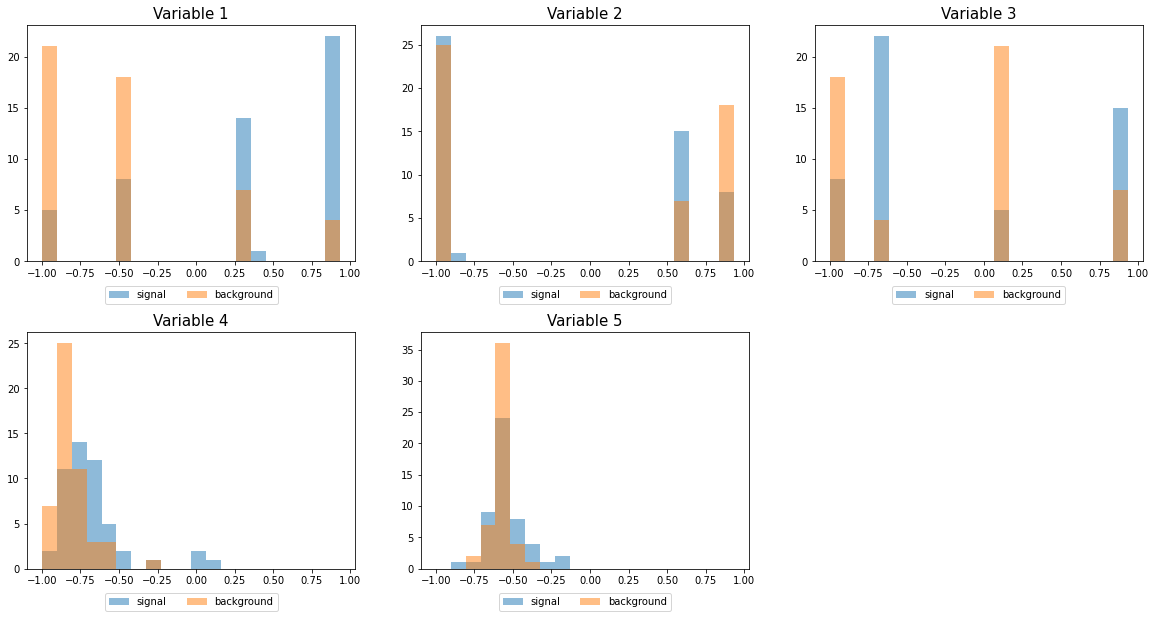

In [17]:
make_plots([x_train_sig, x_train_bkg], ['signal', 'background'])

In [18]:
from typing import Union, Optional
from functools import partial

import numpy as np
import cirq
import tensorflow as tf
from tensorflow.keras.models import Sequential
import tensorflow_quantum as tfq
from sklearn.metrics import roc_curve, auc, roc_auc_score

import quple
from quple.interface.tfq.layers.pqc import PQC
from quple.utils.utils import plot_roc_curve

class QGAN(object):
    """Quantum Generative Adversarial Network (QGAN)
    """    
    def __init__(self, generator_circuit:"cirq.Circuit", discriminator_circuit:"cirq.Circuit",
                 encoding_circuit:"cirq.Circuit",
                 epochs:int=100, batch_size:int=10,   
                 g_lr:float=1e-3, d_lr:float=1e-3, g_activation='tanh', 
                 d_activation=tf.keras.layers.LeakyReLU(alpha=0.2),
                 g_readout=None,
                 d_readout=None,                 
                 differentiator:Optional[tfq.differentiators.Differentiator]=None,
                 regularizer=None,
                 repetitions=None,                 
                 random_state:Optional[int]=None, 
                 name:str='QGAN', *arg, **args):
        """ Creates a QGAN model equipped with a generator and a discriminator
            The only difference between WGAN and DCGAN is in the definition of
            the loss function and the discriminator step per generator step and
            possibly the choice of activation function
        Args:
            generator: cirq.Circuit or quple.QuantumCircuit instace
                A parameterised quantum circuit as a variational quantum generator (VQG)
            discriminator: cirq.Circuit or quple.QuantumCircuit instace
                A parameterised quantum circuit as a variational quantum discriminator (VQD)
            encoding_circuit: cirq.Circuit or quple.QuantumCircuit instace
                A parameterised quantum circuit for data encoding             
            epochs: int, default=100
                Number of epochs
            batch_size: int, default=10
                Batch size for training
            g_lr: float, default=1e-4
                Learning rate for the Adam optimizer of the generator
            d_lr: float, default=1e-4
                Learning rate for the Adam optimizer of the discriminator
            g_activation: str/callable, default='sigmoid'
                Activation function for the output layer of generator
            d_activation: str/callable, default='tanh'
                Activation function for the output layer of discriminator 
            g_readout: `cirq.PauliSum` or Python `list` of `cirq.PauliSum` objects, default=None
                Measurement operators (observables) for the variational circuit layer of generator
                If None, defaults to Pauli Z on all qubits
            d_readout: `cirq.PauliSum` or Python `list` of `cirq.PauliSum` objects, default=None
                Measurement operators (observables) for the variational circuit layer of generator                     
                If None, defaults to Pauli Z on first qubit
            differentiator: Optional `tfq.differentiator` object 
                To specify how gradients of variational circuit should be calculated.
            regularizer: Optional `tf.keras.regularizer` object
                Regularizer applied to the parameters of the variational circuit.
            repetitions: int; default=None
                Number of repetitions for measurement           
            random_state: Optional int, default=None
                The random state for reproducible result.
            name: Optional str, default="QGAN"
                Name given to the classifier.                
        """
        # initialize hyperparameters first
        self.epochs = epochs
        self.batch_size = batch_size
        self.g_lr = g_lr
        self.d_lr = d_lr        
        self.g_activation = g_activation
        self.d_activation = d_activation
        self.differentiator = differentiator
        self.regularizer = regularizer
        self.repetitions = repetitions
        self.g_readout = g_readout
        self.d_readout = d_readout
        self.encoding_circuit = encoding_circuit
        # latent dimension is the same as number of features (= number of qubits)
        self.latent_dim = len(quple.get_circuit_qubits(encoding_circuit))
        self.random_state = random_state
        self.set_random_state(self.random_state)
        # create generator and discriminator models from parameterized quantum circuit
        self.G = self.create_generator(generator_circuit)
        self.D = self.create_discriminator(discriminator_circuit)
        # create optimizers
        self.G_optimizer = tf.keras.optimizers.Adam(learning_rate=self.g_lr)
        self.D_optimizer = tf.keras.optimizers.Adam(learning_rate=self.d_lr)
        
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        
        self.name = name
        
        print('Summary of Generator')
        self.G.summary()
        
        print('Summary of Discriminator')
        self.D.summary()
    
    @staticmethod
    def set_random_state(random_state=None):
        tf.random.set_seed(random_state)
        np.random.seed(random_state)        
        
    def create_generator(self, quantum_circuit:"cirq.Circuit"):
        generator = Sequential()
        # input layer for feeding classical data
        input_layer = tf.keras.layers.Input(shape=(self.latent_dim), dtype=tf.float32)
        # variational layer 
        qubits = quple.get_circuit_qubits(quantum_circuit)
        if not self.g_readout:
            g_readout = [cirq.Z(qubit) for qubit in qubits]
        else:
            g_readout = self.g_readout
        pqc_layer = PQC(quantum_circuit,
                        self.encoding_circuit,
                        g_readout,
                        repetitions=self.repetitions,
                        differentiator=self.differentiator,
                        regularizer=self.regularizer)
        # classical layer for processing quantum output
        output_layer = tf.keras.layers.Dense(self.latent_dim, activation=self.g_activation)
        
        # create generator model
        generator.add(input_layer)
        generator.add(pqc_layer)
        generator.add(output_layer)
        return generator
    
    def create_discriminator(self, quantum_circuit:"cirq.Circuit"):
        discriminator = Sequential()
        # input layer for feeding classical data
        input_layer = tf.keras.layers.Input(shape=(self.latent_dim), dtype=tf.float32)        
        # variational layer 
        qubits = quple.get_circuit_qubits(quantum_circuit)
        if not self.d_readout:
            # by default measure PauliZ on first qubit
            d_readout = [cirq.Z(qubits[0])]
        else:
            d_readout = self.d_readout    
        pqc_layer = PQC(quantum_circuit,
                        self.encoding_circuit,
                        d_readout,
                        repetitions=self.repetitions,
                        differentiator=self.differentiator,
                        regularizer=self.regularizer)
        # classical layer for adding bias to the quantum output
        output_layer = tf.keras.layers.Dense(1, activation=self.d_activation)
        
        # create generator model
        discriminator.add(input_layer)
        discriminator.add(pqc_layer)
        discriminator.add(output_layer)
        return discriminator
    
    def D_loss(self, real_output, fake_output):
        """Compute discriminator loss."""
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def G_loss(self, fake_output):
        """Compute generator loss."""
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)
    
    def to_prob(self, x):
        """Convert discriminator output to probabilities"""
        return tf.divide(tf.add(x, 1), 2)
    
    def train_step(self, x_real, real_noise=0.0):
        """Training step for one epoch"""
        noise = tf.random.normal([self.batch_size, self.latent_dim])
        #x_real_w_noise = tf.add(x_real, tf.random.normal(shape=x_real.shape, 
        #                                           mean=0.0, 
        #                                           stddev=real_noise, dtype=x_real.dtype))
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            x_fake = self.G(noise, training=True)
            real_output = self.D(x_real, training=True)
            p_real = self.to_prob(real_output) 
            fake_output = self.D(x_fake, training=True)
            p_fake = self.to_prob(fake_output) 
            gen_loss = self.G_loss(p_fake)
            disc_loss = self.D_loss(p_real, p_fake)

        grad_gen = gen_tape.gradient(gen_loss, self.G.trainable_variables)
        grad_disc = disc_tape.gradient(disc_loss, self.D.trainable_variables)
        self.G_optimizer.apply_gradients(zip(grad_gen, self.G.trainable_variables))
        self.D_optimizer.apply_gradients(zip(grad_disc, self.D.trainable_variables))  
        return gen_loss, disc_loss
    
    @tf.function
    def generate_samples(self, batch_size):
        """Generates sample using random inputs."""
        z = tf.random.normal((batch_size, self.latent_dim))
        return self.G(z, training=False)  
    
    def predict(self, x):
        return self.D(x, training=False)
    
    @staticmethod
    def create_batches(x, batch_size, buffer_size=10000):
        batches = tf.data.Dataset.from_tensor_slices(x).shuffle(buffer_size).batch(batch_size)
        return batches
    
    def train(self, x, interactive_display=True):
        self.set_random_state(self.random_state)
        batches = self.create_batches(x, self.batch_size)
        #sample_size = x.shape[0]
        #z = tf.constant(tf.random.normal((sample_size, self.latent_dim)))
        g_metric = tf.keras.metrics.Mean()
        d_metric = tf.keras.metrics.Mean()
        fig = plt.figure(figsize=(16,9))
        g_loss_arr = []
        d_loss_arr = []
        epoch_arr = []
        
        for epoch in range(self.epochs):
            for batch in batches:
                gen_loss, disc_loss = self.train_step(batch)
                g_metric(gen_loss)
                d_metric(disc_loss)
                
            g_loss_arr.append(g_metric.result())
            d_loss_arr.append(d_metric.result())
            epoch_arr.append(epoch)
            if interactive_display:
                self.display_loss(g_loss_arr, d_loss_arr, epoch_arr)
            g_metric.reset_states()
            d_metric.reset_states()
        if not interactive_display:
            return g_loss_arr, d_loss_arr
    
    def test(self, x, y, plot=True):
        score = self.predict(x)
        fpr, tpr, thresholds = roc_curve(y, score)
        roc_auc = auc(fpr, tpr)
        if plot:
            return plot_roc_curve(fpr, tpr, 'QDCGAN')
        else:
            return roc_auc
        
    def display_loss(self, g_loss, d_loss, epochs):
        ax = plt.gca()
        ax.set_xlim(0, 1.1*epochs[-1])
        ax.cla()
        ax.plot(epochs, g_loss, label="Generator")
        ax.plot(epochs, d_loss, label="Discriminator")
        ax.set_xlabel('Epoch', fontsize=20)
        ax.set_ylabel('Binary Cross Entropy Loss', fontsize=20)
        ax.grid(True)
        ax.legend(fontsize=20)
        display(plt.gcf())
        clear_output(wait = True)    

In [19]:
# this will also load tfq which may take some time to initialize
from quple import ParameterisedCircuit

In [20]:
encoding_circuit = ParameterisedCircuit(n_qubit, copies=2,
                                        rotation_blocks=['H', 'RZ', 'RY'],
                                        entanglement_blocks=['CX'],
                                        parameter_symbol='x',
                                        reuse_param_per_layer=True,
                                        entangle_strategy='alternate_linear')
encoding_circuit

(0, 0): ───H───Rz(x_0)───Ry(x_0)───@───H───Rz(x_0)───Ry(x_0)─────────────@───────
                                   │                                     │
(0, 1): ───H───Rz(x_1)───Ry(x_1)───X───@───H─────────Rz(x_1)───Ry(x_1)───X───@───
                                       │                                     │
(0, 2): ───H───Rz(x_2)───Ry(x_2)───@───X───H─────────Rz(x_2)───Ry(x_2)───@───X───
                                   │                                     │
(0, 3): ───H───Rz(x_3)───Ry(x_3)───X───@───H─────────Rz(x_3)───Ry(x_3)───X───@───
                                       │                                     │
(0, 4): ───H───Rz(x_4)───Ry(x_4)───────X───H─────────Rz(x_4)───Ry(x_4)───────X───

In [21]:
from quple.circuits.variational_circuits import IsingCoupling, EfficientSU2
generator_circuit = IsingCoupling(n_qubit=n_qubit, copies=3,
                                  entangle_strategy='full')

In [22]:
generator_circuit

┌──────────────────┐               ┌──────────────────┐                                                                          ┌──────────────────┐               ┌──────────────────┐                                                                          ┌──────────────────┐               ┌──────────────────┐
(0, 0): ───Ry(θ_0)───Rz(θ_5)───XX──────────XX──────────XX───────────XX───────────────────────────────────────────────────────────────────Ry(θ_20)────Rz(θ_25)───XX──────────XX──────────XX───────────XX───────────────────────────────────────────────────────────────────Ry(θ_40)────Rz(θ_45)───XX──────────XX──────────XX───────────XX───────────────────────────────────────────────────────────────────Ry(θ_60)────Rz(θ_65)──────────────
                               │           │           │            │                                                                                           │           │           │            │                                                                                           │           │           │            │
(0, 1): ───Ry(θ_1)───Rz(θ_6)───XX^(θ_10)───┼───────────┼────────────┼────────XX───────────XX───────────XX────────────────────────────────Ry(θ_21)────Rz(θ_26)───XX^(θ_30)───┼───────────┼────────────┼────────XX───────────XX───────────XX────────────────────────────────Ry(θ_41)────Rz(θ_46)───XX^(θ_50)───┼───────────┼────────────┼────────XX───────────XX───────────XX────────────────────────────────Ry(θ_61)────Rz(θ_66)──────────────
                                           │           │            │        │            │            │                                                                    │           │            │        │            │            │                                                                    │           │            │        │            │            │
(0, 2): ───Ry(θ_2)───Rz(θ_7)───────────────XX^(θ_11)───┼────────────┼────────XX^(θ_14)────┼────────────┼────────XX───────────XX──────────Ry(θ_22)────Rz(θ_27)───────────────XX^(θ_31)───┼────────────┼────────XX^(θ_34)────┼────────────┼────────XX───────────XX──────────Ry(θ_42)────Rz(θ_47)───────────────XX^(θ_51)───┼────────────┼────────XX^(θ_54)────┼────────────┼────────XX───────────XX──────────Ry(θ_62)────Rz(θ_67)──────────────
                                                       │            │                     │            │        │            │                                                          │            │                     │            │        │            │                                                          │            │                     │            │        │            │
(0, 3): ───Ry(θ_3)───Rz(θ_8)───────────────────────────XX^(θ_12)────┼─────────────────────XX^(θ_15)────┼────────XX^(θ_17)────┼───────────XX──────────Ry(θ_23)───Rz(θ_28)────────────────XX^(θ_32)────┼─────────────────────XX^(θ_35)────┼────────XX^(θ_37)────┼───────────XX──────────Ry(θ_43)───Rz(θ_48)────────────────XX^(θ_52)────┼─────────────────────XX^(θ_55)────┼────────XX^(θ_57)────┼───────────XX──────────Ry(θ_63)───Rz(θ_68)───
                                                                    │                                  │                     │           │                                                           │                                  │                     │           │                                                           │                                  │                     │           │
(0, 4): ───Ry(θ_4)───Rz(θ_9)────────────────────────────────────────XX^(θ_13)──────────────────────────XX^(θ_16)─────────────XX^(θ_18)───XX^(θ_19)───Ry(θ_24)───Rz(θ_29)─────────────────────────────XX^(θ_33)──────────────────────────XX^(θ_36)─────────────XX^(θ_38)───XX^(θ_39)───Ry(θ_44)───Rz(θ_49)─────────────────────────────XX^(θ_53)──────────────────────────XX^(θ_56)─────────────XX^(θ_58)───XX^(θ_59)───Ry(θ_64)───Rz(θ_69)───
                                                               

In [23]:
from quple import PauliBlock

In [24]:
discriminator_circuit = ParameterisedCircuit(n_qubit=n_qubit, copies=3,
                                             rotation_blocks=['RZ', 'RY'],
                                             entanglement_blocks = [PauliBlock('ZZ'), PauliBlock('XX')],
                                             entangle_strategy='alternate_linear')

In [25]:
discriminator_circuit

(0, 0): ───Rz(θ_0)───Ry(θ_5)───@──────────────@────────────────────────────────────────H───@──────────────@───H────────────────────────────────────────────────────────────────────────Rz(θ_18)───Ry(θ_23)───@─────────────────────@────────────────────────────────────────H───@──────────────@───H────────────────────────────────────────────────────────────────────────Rz(θ_36)───Ry(θ_41)───@─────────────────────@────────────────────────────────────────H───@──────────────@───H────────────────────────────────────────────────────────────────────────────
                               │              │                                            │              │                                                                                                  │                     │                                            │              │                                                                                                  │                     │                                            │              │
(0, 1): ───Rz(θ_1)───Ry(θ_6)───X───Rz(θ_10)───X──────────────@──────────────@──────────H───X───Rz(θ_14)───X───H──────────────────────H───────@──────────────@───H──────────────────────Rz(θ_19)───Ry(θ_24)───X──────────Rz(θ_28)───X──────────────@──────────────@──────────H───X───Rz(θ_32)───X───H──────────────────────H───────@──────────────@───H──────────────────────Rz(θ_37)───Ry(θ_42)───X──────────Rz(θ_46)───X──────────────@──────────────@──────────H───X───Rz(θ_50)───X───H──────────────────────H───────@──────────────@───H──────────────────────────
                                                             │              │                                                                │              │                                                                                     │              │                                                                │              │                                                                                     │              │                                                                │              │
(0, 2): ───Rz(θ_2)───Ry(θ_7)───@─────────────────────────@───X───Rz(θ_12)───X─────────────────────────────────H───@──────────────@───H───H───X───Rz(θ_16)───X───H──────────────────────Rz(θ_20)───Ry(θ_25)──────────────@─────────────────────@───X───Rz(θ_30)───X─────────────────────────────────H───@──────────────@───H───H───X───Rz(θ_34)───X───H──────────────────────Rz(θ_38)───Ry(θ_43)──────────────@─────────────────────@───X───Rz(θ_48)───X─────────────────────────────────H───@──────────────@───H───H───X───Rz(θ_52)───X───H──────────────────────────
                               │                         │                                                        │              │                                                                                      │                     │                                                        │              │                                                                                      │                     │                                                        │              │
(0, 3): ───Rz(θ_3)───Ry(θ_8)───X──────────────Rz(θ_11)───X───@─────────────────────────@──────────────────────H───X───Rz(θ_15)───X───H──────────────────────────H───@──────────────@───H──────────Rz(θ_21)───Ry(θ_26)───X──────────Rz(θ_29)───X───@─────────────────────────@──────────────────────H───X───Rz(θ_33)───X───H──────────────────────────H───@──────────────@───H──────────Rz(θ_39)───Ry(θ_44)───X──────────Rz(θ_47)───X───@─────────────────────────@──────────────────────H───X───Rz(θ_51)───X───H──────────────────────────H───@──────────────@───H───
                                                             │                         │                                                                            │              │                                                              │                         │                                                

In [26]:
qgan = QGAN(generator_circuit, discriminator_circuit, encoding_circuit=encoding_circuit,
              epochs=100, d_lr=7e-3, g_lr=1e-3, g_activation='tanh', d_activation='linear',
              random_state=2)

Summary of Generator
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 5)                 70        
_________________________________________________________________
dense (Dense)                (None, 5)                 30        
Total params: 100
Trainable params: 100
Non-trainable params: 0
_________________________________________________________________
Summary of Discriminator
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_1 (PQC)                  (None, 1)                 54        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 56
Trainable params: 56
Non-trainable params: 0
____________________________________________________________

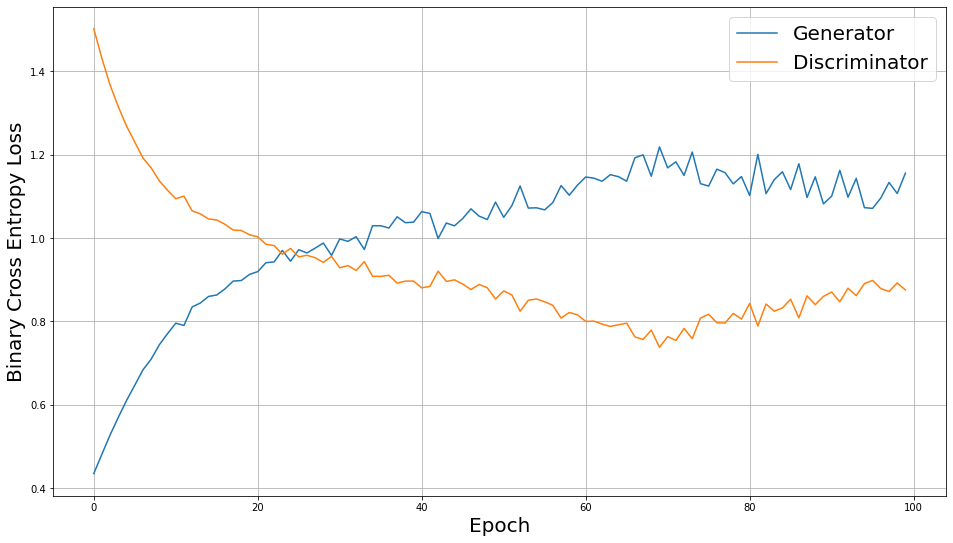

In [27]:
qgan.train(x_train_sig)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

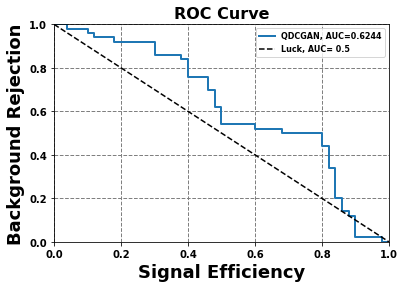

In [28]:
qgan.test(x_test, y_test)

In [29]:
# we first tune learning rate (just simple search space for sake of demonstration)
search_space = {
    'g_lr': [1e-2, 5e-3, 1e-3],
    'd_lr': [1e-2, 5e-3, 1e-3]
}

In [31]:
import itertools
categorical_combinations = [search_space[hp] for hp in search_space]
search_points = list(set(itertools.product(*categorical_combinations)))
search_points = [{hp:value for hp,value in zip(search_space.keys(), point)} for point in search_points]
search_points

[{'d_lr': 0.01, 'g_lr': 0.001},
 {'d_lr': 0.005, 'g_lr': 0.005},
 {'d_lr': 0.01, 'g_lr': 0.005},
 {'d_lr': 0.01, 'g_lr': 0.01},
 {'d_lr': 0.005, 'g_lr': 0.001},
 {'d_lr': 0.001, 'g_lr': 0.01},
 {'d_lr': 0.001, 'g_lr': 0.001},
 {'d_lr': 0.005, 'g_lr': 0.01},
 {'d_lr': 0.001, 'g_lr': 0.005}]

In [32]:
result = []
models = []
for point in search_points:
    print('INFO: Training QGAN with the hyperparameters: {}'.format(point))
    model = QGAN(generator_circuit, discriminator_circuit, encoding_circuit=encoding_circuit,
              epochs=100, g_activation='tanh', d_activation='linear',
              random_state=2, **point)
    model.train(x_train_sig, interactive_display=False)
    roc_auc = model.test(x_test, y_test, plot=False)
    print('INFO: Test AUC = {}'.format(roc_auc))
    result.append(roc_auc)
    models.append(model)

INFO: Training QGAN with the hyperparameters: {'g_lr': 0.001, 'd_lr': 0.01}
Summary of Generator
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_2 (PQC)                  (None, 5)                 70        
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 30        
Total params: 100
Trainable params: 100
Non-trainable params: 0
_________________________________________________________________
Summary of Discriminator
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_3 (PQC)                  (None, 1)                 54        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2         
Total params: 56
Trainable params: 56
Non-tr

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

In [33]:
result = np.array(result)
best_config_lr = search_points[np.argmax(result)]
print('The best lr combination so far is:')
print(best_config_lr)
print('With test auc = {}'.format(np.max(result)))

The best lr combination so far is:
{'g_lr': 0.01, 'd_lr': 0.001}
With test auc = 0.7544000000000001


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

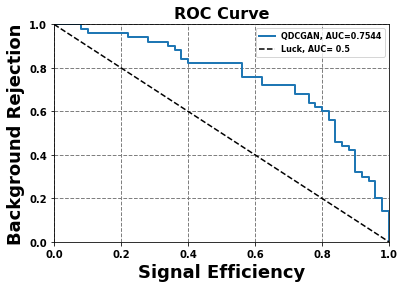

In [34]:
models[np.argmax(result)].test(x_test, y_test)

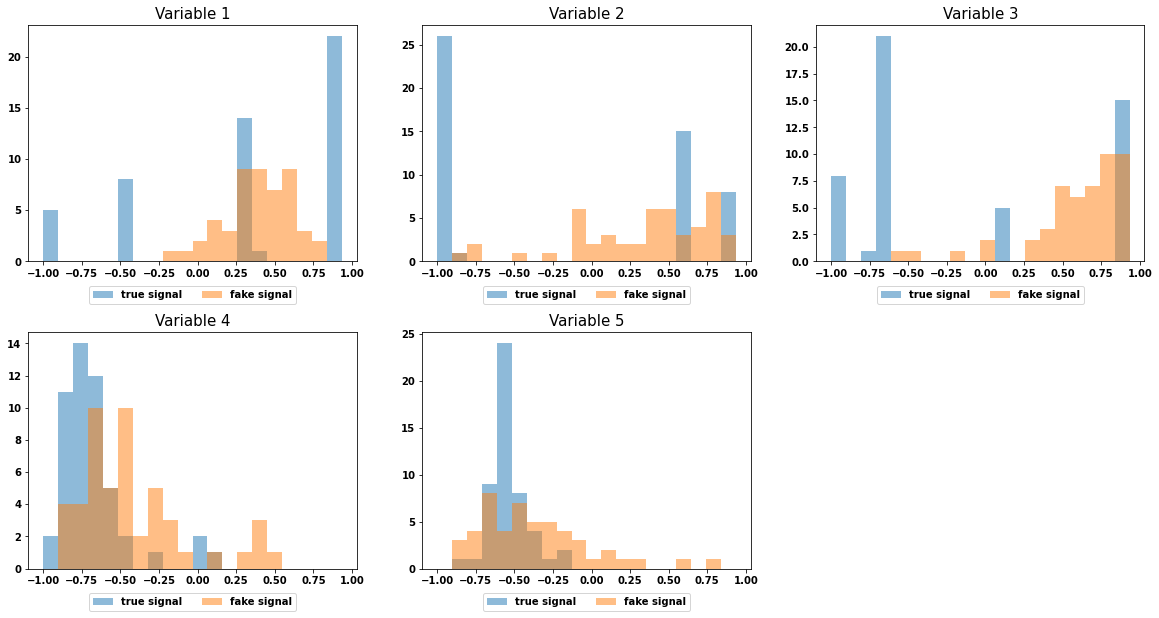

In [25]:
samples = qgan.generate_samples(batch_size=50).numpy()
make_plots([x_train_sig, samples], ['true signal', 'fake signal'])

# GPU SPEEDUP AND MULTI LAYERS

Other things to investigate:

- Use of different **differentiators** from `tensorflow_quantum`. For example the `tfq.differentiators.ParameterShift()` method which can potentially give good performance but with a faster execution time.

In [31]:
from typing import Union, Optional
from functools import partial

import numpy as np
import cirq
import tensorflow as tf
from tensorflow.keras.models import Sequential
import tensorflow_quantum as tfq
from sklearn.metrics import roc_curve, auc, roc_auc_score

import quple
from quple.interface.tfq.layers.pqc import PQC
from quple.utils.utils import plot_roc_curve

class QGAN(object):
    """Quantum Generative Adversarial Network (QGAN)
    """    
    def __init__(self, generator_circuit:"cirq.Circuit", discriminator_circuit:"cirq.Circuit",
                 encoding_circuit:"cirq.Circuit",
                 epochs:int=100, batch_size:int=10,   
                 g_lr:float=1e-3, d_lr:float=1e-3, g_activation='tanh', 
                 d_activation=tf.keras.layers.LeakyReLU(alpha=0.2),
                 g_readout=None,
                 d_readout=None,                 
                 differentiator:Optional[tfq.differentiators.Differentiator]=None,
                 regularizer=None,
                 repetitions=None,                 
                 random_state:Optional[int]=None, 
                 name:str='QGAN', *arg, **args):
        """ Creates a QGAN model equipped with a generator and a discriminator
            The only difference between WGAN and DCGAN is in the definition of
            the loss function and the discriminator step per generator step and
            possibly the choice of activation function
        Args:
            generator: cirq.Circuit or quple.QuantumCircuit instace
                A parameterised quantum circuit as a variational quantum generator (VQG)
            discriminator: cirq.Circuit or quple.QuantumCircuit instace
                A parameterised quantum circuit as a variational quantum discriminator (VQD)
            encoding_circuit: cirq.Circuit or quple.QuantumCircuit instace
                A parameterised quantum circuit for data encoding             
            epochs: int, default=100
                Number of epochs
            batch_size: int, default=10
                Batch size for training
            g_lr: float, default=1e-4
                Learning rate for the Adam optimizer of the generator
            d_lr: float, default=1e-4
                Learning rate for the Adam optimizer of the discriminator
            g_activation: str/callable, default='sigmoid'
                Activation function for the output layer of generator
            d_activation: str/callable, default='tanh'
                Activation function for the output layer of discriminator 
            g_readout: `cirq.PauliSum` or Python `list` of `cirq.PauliSum` objects, default=None
                Measurement operators (observables) for the variational circuit layer of generator
                If None, defaults to Pauli Z on all qubits
            d_readout: `cirq.PauliSum` or Python `list` of `cirq.PauliSum` objects, default=None
                Measurement operators (observables) for the variational circuit layer of generator                     
                If None, defaults to Pauli Z on first qubit
            differentiator: Optional `tfq.differentiator` object 
                To specify how gradients of variational circuit should be calculated.
            regularizer: Optional `tf.keras.regularizer` object
                Regularizer applied to the parameters of the variational circuit.
            repetitions: int; default=None
                Number of repetitions for measurement           
            random_state: Optional int, default=None
                The random state for reproducible result.
            name: Optional str, default="QGAN"
                Name given to the classifier.                
        """
        # initialize hyperparameters first
        self.epochs = epochs
        self.batch_size = batch_size
        self.g_lr = g_lr
        self.d_lr = d_lr        
        self.g_activation = g_activation
        self.d_activation = d_activation
        self.differentiator = differentiator
        self.regularizer = regularizer
        self.repetitions = repetitions
        self.g_readout = g_readout
        self.d_readout = d_readout
        self.encoding_circuit = encoding_circuit
        # latent dimension is the same as number of features (= number of qubits)
        self.latent_dim = len(quple.get_circuit_qubits(encoding_circuit))
        self.random_state = random_state
        self.set_random_state(self.random_state)
        # create generator and discriminator models from parameterized quantum circuit
        self.G = self.create_generator(generator_circuit)
        self.D = self.create_discriminator(discriminator_circuit)
        # create optimizers
        self.G_optimizer = tf.keras.optimizers.Adam(learning_rate=self.g_lr)
        self.D_optimizer = tf.keras.optimizers.Adam(learning_rate=self.d_lr)
        
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        
        self.name = name
        
        print('Summary of Generator')
        self.G.summary()
        
        print('Summary of Discriminator')
        self.D.summary()
    
    @staticmethod
    def set_random_state(random_state=None):
        tf.random.set_seed(random_state)
        np.random.seed(random_state)        
        
    def create_generator(self, quantum_circuit:"cirq.Circuit"):
        generator = Sequential()
        # input layer for feeding classical data
        input_layer = tf.keras.layers.Input(shape=(self.latent_dim), dtype=tf.float32)
        # variational layer 
        qubits = quple.get_circuit_qubits(quantum_circuit)
        if not self.g_readout:
            g_readout = [cirq.Z(qubit) for qubit in qubits]
        else:
            g_readout = self.g_readout
        pqc_layer = PQC(quantum_circuit,
                        self.encoding_circuit,
                        g_readout,
                        repetitions=self.repetitions,
                        differentiator=self.differentiator,
                        regularizer=self.regularizer)
        # classical layer for processing quantum output
        output_layer = tf.keras.layers.Dense(self.latent_dim, activation=self.g_activation)
        
        # create generator model
        generator.add(input_layer)
        generator.add(pqc_layer)
        generator.add(output_layer)
        
        #refresh differentiator
        differentiator.refresh()

        return generator
    
    def create_discriminator(self, quantum_circuit:"cirq.Circuit"):
        discriminator = Sequential()
        # input layer for feeding classical data
        input_layer = tf.keras.layers.Input(shape=(self.latent_dim), dtype=tf.float32)        
        # variational layer 
        qubits = quple.get_circuit_qubits(quantum_circuit)
        if not self.d_readout:
            # by default measure PauliZ on first qubit
            d_readout = [cirq.Z(qubits[0])]
        else:
            d_readout = self.d_readout    
        pqc_layer = PQC(quantum_circuit,
                        self.encoding_circuit,
                        d_readout,
                        repetitions=self.repetitions,
                        differentiator=self.differentiator,
                        regularizer=self.regularizer)
        # classical layer for adding bias to the quantum output
        output_layer = tf.keras.layers.Dense(1, activation=self.d_activation)
        
        # create generator model
        discriminator.add(input_layer)
        discriminator.add(pqc_layer)
        discriminator.add(output_layer)
        
        #refresh differentiator
        differentiator.refresh()
            
        return discriminator
    
    def D_loss(self, real_output, fake_output):
        """Compute discriminator loss."""
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        #refresh differentiator
        differentiator.refresh()
        return total_loss

    def G_loss(self, fake_output):
        """Compute generator loss."""
        #refresh differentiator
        differentiator.refresh()
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)
    
    def to_prob(self, x):
        """Convert discriminator output to probabilities"""
        #refresh differentiator
        differentiator.refresh()
        return tf.divide(tf.add(x, 1), 2)
    
    def train_step(self, x_real, real_noise=0.0):
        """Training step for one epoch"""
        noise = tf.random.normal([self.batch_size, self.latent_dim])
        #x_real_w_noise = tf.add(x_real, tf.random.normal(shape=x_real.shape, 
        #                                           mean=0.0, 
        #                                           stddev=real_noise, dtype=x_real.dtype))
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            x_fake = self.G(noise, training=True)
            real_output = self.D(x_real, training=True)
            p_real = self.to_prob(real_output) 
            fake_output = self.D(x_fake, training=True)
            p_fake = self.to_prob(fake_output) 
            gen_loss = self.G_loss(p_fake)
            disc_loss = self.D_loss(p_real, p_fake)

        grad_gen = gen_tape.gradient(gen_loss, self.G.trainable_variables)
        grad_disc = disc_tape.gradient(disc_loss, self.D.trainable_variables)
        self.G_optimizer.apply_gradients(zip(grad_gen, self.G.trainable_variables))
        self.D_optimizer.apply_gradients(zip(grad_disc, self.D.trainable_variables))
        
        #refresh differentiator
        differentiator.refresh()
              
        return gen_loss, disc_loss
    
    @tf.function
    def generate_samples(self, batch_size):
        """Generates sample using random inputs."""
        z = tf.random.normal((batch_size, self.latent_dim))
        #refresh differentiator
        differentiator.refresh()
        return self.G(z, training=False)  
    
    def predict(self, x):
      #refresh differentiator
        differentiator.refresh()
        return self.D(x, training=False)
    
    @staticmethod
    def create_batches(x, batch_size, buffer_size=10000):
        batches = tf.data.Dataset.from_tensor_slices(x).shuffle(buffer_size).batch(batch_size)
        #refresh differentiator
        differentiator.refresh()
        return batches
    
    def train(self, x, interactive_display=True):
        self.set_random_state(self.random_state)
        batches = self.create_batches(x, self.batch_size)
        #sample_size = x.shape[0]
        #z = tf.constant(tf.random.normal((sample_size, self.latent_dim)))
        g_metric = tf.keras.metrics.Mean()
        d_metric = tf.keras.metrics.Mean()
        fig = plt.figure(figsize=(16,9))
        g_loss_arr = []
        d_loss_arr = []
        epoch_arr = []
        
        for epoch in range(self.epochs):
            for batch in batches:
                gen_loss, disc_loss = self.train_step(batch)
                g_metric(gen_loss)
                d_metric(disc_loss)
                
            g_loss_arr.append(g_metric.result())
            d_loss_arr.append(d_metric.result())
            epoch_arr.append(epoch)
            
            #refresh differentiator
            differentiator.refresh()
            
            if interactive_display:
                self.display_loss(g_loss_arr, d_loss_arr, epoch_arr)
            g_metric.reset_states()
            d_metric.reset_states()
        if not interactive_display:
            return g_loss_arr, d_loss_arr
    
    def test(self, x, y, plot=True):
        score = self.predict(x)
        fpr, tpr, thresholds = roc_curve(y, score)
        roc_auc = auc(fpr, tpr)
        #refresh differentiator
        differentiator.refresh()
        if plot:
            return plot_roc_curve(fpr, tpr, 'QDCGAN')
        else:
            return roc_auc
        
    def display_loss(self, g_loss, d_loss, epochs):
        ax = plt.gca()
        ax.set_xlim(0, 1.1*epochs[-1])
        ax.cla()
        ax.plot(epochs, g_loss, label="Generator")
        ax.plot(epochs, d_loss, label="Discriminator")
        ax.set_xlabel('Epoch', fontsize=20)
        ax.set_ylabel('Binary Cross Entropy Loss', fontsize=20)
        ax.grid(True)
        ax.legend(fontsize=20)
        display(plt.gcf())
        clear_output(wait = True)    

In [36]:
# differentiator = tfq.differentiators.ForwardDifference() # NOT BEING USED HERE
qgan = QGAN(generator_circuit, discriminator_circuit, encoding_circuit=encoding_circuit,
              epochs=100, d_lr=7e-3, g_lr=1e-3,
              random_state=2)

Summary of Generator
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_28 (PQC)                 (None, 5)                 70        
_________________________________________________________________
dense_28 (Dense)             (None, 5)                 30        
Total params: 100
Trainable params: 100
Non-trainable params: 0
_________________________________________________________________
Summary of Discriminator
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_29 (PQC)                 (None, 1)                 54        
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 2         
Total params: 56
Trainable params: 56
Non-trainable params: 0
________________________________________________________

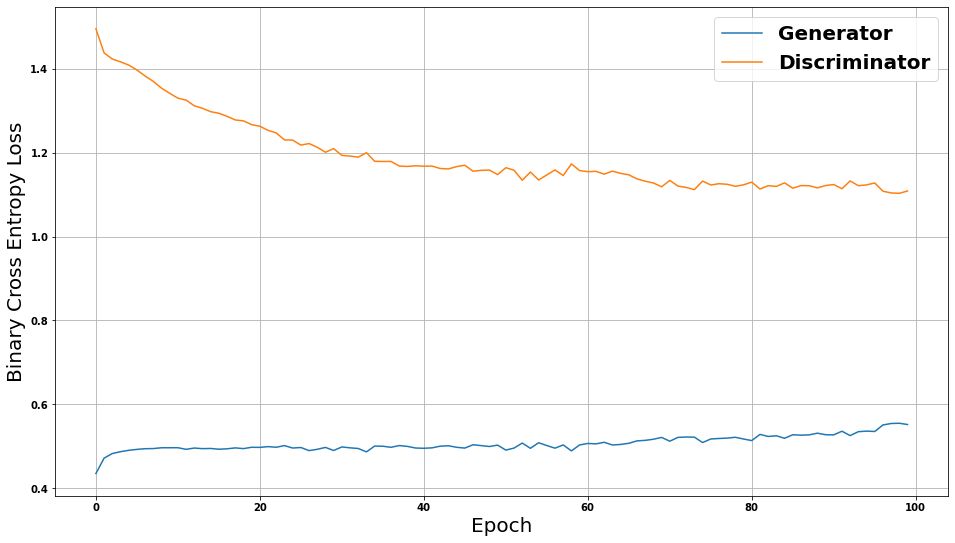

In [37]:
qgan.train(x_train_sig)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

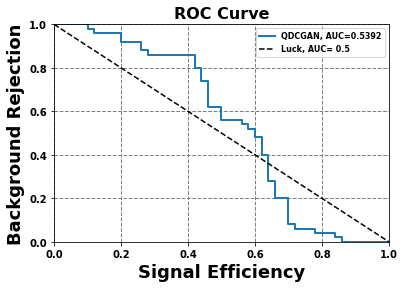

In [38]:
qgan.test(x_test, y_test)

In [39]:
# we first tune learning rate (just simple search space for sake of demonstration)
search_space = {
    'g_lr': [1e-2, 5e-3, 1e-3],
    'd_lr': [1e-2, 5e-3, 1e-3]
}

In [40]:
import itertools
categorical_combinations = [search_space[hp] for hp in search_space]
search_points = list(set(itertools.product(*categorical_combinations)))
search_points = [{hp:value for hp,value in zip(search_space.keys(), point)} for point in search_points]
search_points

[{'d_lr': 0.01, 'g_lr': 0.001},
 {'d_lr': 0.005, 'g_lr': 0.005},
 {'d_lr': 0.01, 'g_lr': 0.005},
 {'d_lr': 0.01, 'g_lr': 0.01},
 {'d_lr': 0.005, 'g_lr': 0.001},
 {'d_lr': 0.001, 'g_lr': 0.01},
 {'d_lr': 0.001, 'g_lr': 0.001},
 {'d_lr': 0.005, 'g_lr': 0.01},
 {'d_lr': 0.001, 'g_lr': 0.005}]

In [41]:
result = []
models = []
for point in search_points:
    print('INFO: Training QGAN with the hyperparameters: {}'.format(point))
    model = QGAN(generator_circuit, discriminator_circuit, encoding_circuit=encoding_circuit,
              epochs=100, g_activation='tanh', d_activation='linear',
              random_state=2, **point)
    model.train(x_train_sig, interactive_display=False)
    roc_auc = model.test(x_test, y_test, plot=False)
    print('INFO: Test AUC = {}'.format(roc_auc))
    result.append(roc_auc)
    models.append(model)

INFO: Training QGAN with the hyperparameters: {'g_lr': 0.001, 'd_lr': 0.01}
Summary of Generator
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_30 (PQC)                 (None, 5)                 70        
_________________________________________________________________
dense_30 (Dense)             (None, 5)                 30        
Total params: 100
Trainable params: 100
Non-trainable params: 0
_________________________________________________________________
Summary of Discriminator
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_31 (PQC)                 (None, 1)                 54        
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 2         
Total params: 56
Trainable params: 56
Non-

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

In [42]:
result = np.array(result)
best_config_lr = search_points[np.argmax(result)]
print('The best lr combination so far is:')
print(best_config_lr)
print('With test auc = {}'.format(np.max(result)))

The best lr combination so far is:
{'g_lr': 0.01, 'd_lr': 0.001}
With test auc = 0.7544000000000001


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

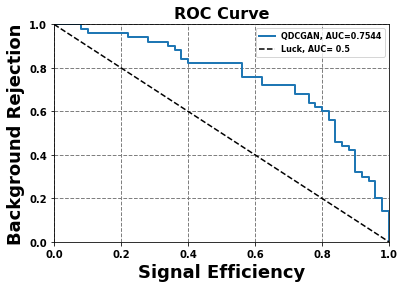

In [43]:
models[np.argmax(result)].test(x_test, y_test)

# QWGAN

In [35]:
from typing import Union, Optional
from functools import partial

import cirq
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
import tensorflow_quantum as tfq
from tqdm import tqdm

import quple
from quple.interface.tfq.layers.pqc import PQC

class QWGAN(object):
    """Quantum Wasserstein Generative Adversarial Network (QWGAN)
    """    
    def __init__(self, generator_circuit:"cirq.Circuit", discriminator_circuit:"cirq.Circuit",
                 encoding_circuit:"cirq.Circuit",
                 epochs:int=100, batch_size:int=10, n_critic:int=5, weight_gp:float=10, 
                 g_lr:float=1e-4, d_lr:float=1e-4, g_activation='tanh', 
                 d_activation=tf.keras.layers.LeakyReLU(alpha=0.01),
                 #tf.keras.layers.LeakyReLU(alpha=0.01)
                 g_readout=None,
                 d_readout=None,                 
                 differentiator:Optional[tfq.differentiators.Differentiator]=None,
                 regularizer=None,
                 repetitions=None,                 
                 random_state:Optional[int]=None, 
                 name:str='QWGAN', *arg, **args):
        """ Creates a QWGAN model equipped with a generator and a discriminator
        Args:
            generator: cirq.Circuit or quple.QuantumCircuit instace
                A parameterised quantum circuit as a variational quantum generator (VQG)
            discriminator: cirq.Circuit or quple.QuantumCircuit instace
                A parameterised quantum circuit as a variational quantum discriminator (VQD)
            encoding_circuit: cirq.Circuit or quple.QuantumCircuit instace
                A parameterised quantum circuit for data encoding             
            epochs: int, default=100
                Number of epochs
            batch_size: int, default=10
                Batch size for training
            n_critic: int, default=5
                Number of critic (discriminator) iterations to run for every generator iteration
            weight_gp: float, default=10
                The weight of gradient penalty (i.e. lambda) to use
            g_lr: float, default=1e-4
                Learning rate for the Adam optimizer of the generator
            d_lr: float, default=1e-4
                Learning rate for the Adam optimizer of the discriminator
            g_activation: str/callable, default='tanh'
                Activation function for the output layer of generator
            d_activation: str/callable, default=LeakyReLU
                Activation function for the output layer of discriminator 
            g_readout: `cirq.PauliSum` or Python `list` of `cirq.PauliSum` objects, default=None
                Measurement operators (observables) for the variational circuit layer of generator
                If None, defaults to Pauli Z on all qubits
            d_readout: `cirq.PauliSum` or Python `list` of `cirq.PauliSum` objects, default=None
                Measurement operators (observables) for the variational circuit layer of generator                     
                If None, defaults to Pauli Z on first qubit
            differentiator: Optional `tfq.differentiator` object 
                To specify how gradients of variational circuit should be calculated.
            regularizer: Optional `tf.keras.regularizer` object
                Regularizer applied to the parameters of the variational circuit.
            repetitions: int; default=None
                Number of repetitions for measurement           
            random_state: Optional int, default=None
                The random state for reproducible result.
            name: Optional str, default="QWGAN"
                Name given to the classifier.                
        """
        # initialize hyperparameters first
        self.epochs = epochs
        self.batch_size = batch_size
        self.n_critic = n_critic
        self.weight_gp = weight_gp
        self.g_lr = g_lr
        self.d_lr = d_lr        
        self.g_activation = g_activation
        self.d_activation = d_activation
        self.differentiator = differentiator
        self.regularizer = regularizer
        self.repetitions = repetitions
        self.g_readout = g_readout
        self.d_readout = d_readout
        self.encoding_circuit = encoding_circuit
        # latent dimension is the same as number of features (= number of qubits)
        self.latent_dim = len(quple.get_circuit_qubits(encoding_circuit))
        self.random_state = random_state
        self.set_random_state(self.random_state)
        # create generator and discriminator models from parameterized quantum circuit
        self.G = self.create_generator(generator_circuit)
        self.D = self.create_discriminator(discriminator_circuit)
        # create optimizers
        self.G_optimizer = tf.keras.optimizers.Adam(learning_rate=self.g_lr)
        self.D_optimizer = tf.keras.optimizers.Adam(learning_rate=self.d_lr)
        
        self.name = name
        
        print('Summary of Generator')
        self.G.summary()
        
        print('Summary of Discriminator')
        self.D.summary()     
        
    @staticmethod
    def set_random_state(random_state=None):
        tf.random.set_seed(random_state)
        np.random.seed(random_state)               
        
    def create_generator(self, quantum_circuit:"cirq.Circuit"):
        generator = Sequential()
        # input layer for feeding classical data
        input_layer = tf.keras.layers.Input(shape=(self.latent_dim), dtype=tf.float32)
        # variational layer 
        qubits = quple.get_circuit_qubits(quantum_circuit)
        if not self.g_readout:
            g_readout = [cirq.Z(qubit) for qubit in qubits]
        else:
            g_readout = self.g_readout
        pqc_layer = PQC(quantum_circuit,
                        self.encoding_circuit,
                        g_readout,
                        repetitions=self.repetitions,
                        differentiator=self.differentiator,
                        regularizer=self.regularizer)
        # classical layer for processing quantum output
        output_layer = tf.keras.layers.Dense(self.latent_dim, activation=self.g_activation)
        
        # create generator model
        generator.add(input_layer)
        generator.add(pqc_layer)
        generator.add(output_layer)
        return generator
    
    def create_discriminator(self, quantum_circuit:"cirq.Circuit"):
        discriminator = Sequential()
        # input layer for feeding classical data
        input_layer = tf.keras.layers.Input(shape=(self.latent_dim), dtype=tf.float32)        
        # variational layer 
        qubits = quple.get_circuit_qubits(quantum_circuit)
        if not self.d_readout:
            # by default measure PauliZ on first qubit
            d_readout = [cirq.Z(qubits[0])]
        else:
            d_readout = self.d_readout    
        pqc_layer = PQC(quantum_circuit,
                        self.encoding_circuit,
                        d_readout,
                        repetitions=self.repetitions,
                        differentiator=self.differentiator,
                        regularizer=self.regularizer)
        # classical layer for adding bias to the quantum output
        output_layer = tf.keras.layers.Dense(1, activation=self.d_activation)
        
        # create generator model
        discriminator.add(input_layer)
        discriminator.add(pqc_layer)
        discriminator.add(output_layer)
        return discriminator
    
    def D_loss(self, real_output, fake_output):
        """Compute discriminator loss."""
        return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

    def G_loss(self, fake_output):
        """Compute generator loss."""
        return -tf.reduce_mean(fake_output)
    
    @tf.function 
    def G_step(self):
        """Perform one training step for generator"""
        # using Gaussian noise with mean 0 and width 1 as generator input
        noise = tf.random.normal((self.batch_size, self.latent_dim))
        with tf.GradientTape() as t:
            x_fake = self.G(noise, training=True)
            fake_output = self.D(x_fake, training=True)
            loss = self.G_loss(fake_output)
        grad = t.gradient(loss, self.G.trainable_variables)
        self.G_optimizer.apply_gradients(zip(grad, self.G.trainable_variables))
        return loss
    
    @tf.function
    def D_step(self, x_real):
        """Perform one training step for discriminator"""
        x_real = tf.dtypes.cast(x_real, tf.float32)
        # using Gaussian noise with mean 0 and width 1 as generator input
        noise = tf.random.normal(x_real.shape, dtype=tf.float32)
        with tf.GradientTape() as t:
            x_fake = self.G(noise, training=True)
            real_output = self.D(x_real, training=True)
            fake_output = self.D(x_fake, training=True)
            # compute Wasserstein loss: (x_fake - x_real) + gp_weight*gradient_term
            cost = self.D_loss(real_output, fake_output)
            # since tfq does not supoprt 2nd order derivative we can't evaluate
            # cost with gradient penalty for the moment
            #gp = self.gradient_penalty(partial(self.D, training=True), x_real, x_fake)
            #cost = self.weight_gp * gp
        grad = t.gradient(cost, self.D.trainable_variables)
        self.D_optimizer.apply_gradients(zip(grad, self.D.trainable_variables))
        return cost  

    @tf.function
    def gradient_penalty(self, f, x_real, x_fake):
        alpha = tf.random.uniform([self.batch_size, 1], 0., 1.)
        diff = x_fake - x_real
        inter = x_real + (alpha * diff)
        with tf.GradientTape() as t:
            t.watch(inter)
            pred = f(inter)
        grad = t.gradient(pred, [inter])[0]
        slopes = tf.sqrt(tf.reduce_sum(tf.square(grad), axis=1))
        gp = tf.reduce_mean((slopes - 1.)**2)
        return gp    
    
    @tf.function
    def generate_samples(self, batch_size):
        """Generates sample using random inputs."""
        z = tf.random.normal((batch_size, self.latent_dim))
        return self.G(z, training=False)  
    
    def predict(self, x):
        return self.D(x, training=False) 
    
    @staticmethod
    def create_batches(x, batch_size, buffer_size=10000):
        batches = tf.data.Dataset.from_tensor_slices(x).shuffle(buffer_size).batch(batch_size)
        return batches
    
    def train(self, x, interactive_display=True):
        self.set_random_state(self.random_state)
        batches = self.create_batches(x, self.batch_size)
        #sample_size = x.shape[0]
        #z = tf.constant(tf.random.normal((sample_size, self.latent_dim)))
        g_metric = tf.keras.metrics.Mean()
        d_metric = tf.keras.metrics.Mean()
        fig = plt.figure(figsize=(16,9))
        g_loss_arr = []
        d_loss_arr = []
        epoch_arr = []
        
        for epoch in range(self.epochs):
            for batch in batches:
                for _ in range(self.n_critic):
                    d_loss = self.D_step(batch)
                    d_metric(d_loss)
                g_loss = self.G_step()
                g_metric(g_loss)
                
            g_loss_arr.append(g_metric.result())
            d_loss_arr.append(d_metric.result())
            epoch_arr.append(epoch)
            
            if interactive_display:
                self.display_loss(g_loss_arr, d_loss_arr, epoch_arr)
            g_metric.reset_states()
            d_metric.reset_states()
            
        if not interactive_display:
            return g_loss_arr, d_loss_arr
            
    def test(self, x, y, plot=True):
        score = self.predict(x)
        fpr, tpr, thresholds = roc_curve(y, score)
        roc_auc = auc(fpr, tpr)
        if plot:
            return plot_roc_curve(fpr, tpr, 'QWGAN')
        else:
            return roc_auc
        
    def display_loss(self, g_loss, d_loss, epochs):
        ax = plt.gca()
        ax.set_xlim(0, 1.1*epochs[-1])
        ax.cla()
        ax.plot(epochs, g_loss, label="Generator")
        ax.plot(epochs, d_loss, label="Discriminator")
        ax.set_xlabel('Epoch', fontsize=20)
        ax.set_ylabel('Wasserstein Loss', fontsize=20)
        ax.grid(True)
        ax.legend(fontsize=20)
        display(plt.gcf())
        clear_output(wait = True)    

In [38]:
qwgan = QWGAN(generator_circuit, discriminator_circuit, encoding_circuit=encoding_circuit,
              epochs=100, d_lr=1e-4, g_lr=1e-3, g_activation='tanh', d_activation='linear',
              random_state=2)
# tf.keras.layers.LeakyReLU(alpha=0.1)

Summary of Generator
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_24 (PQC)                 (None, 5)                 70        
_________________________________________________________________
dense_24 (Dense)             (None, 5)                 30        
Total params: 100
Trainable params: 100
Non-trainable params: 0
_________________________________________________________________
Summary of Discriminator
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_25 (PQC)                 (None, 1)                 54        
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 2         
Total params: 56
Trainable params: 56
Non-trainable params: 0
________________________________________________________

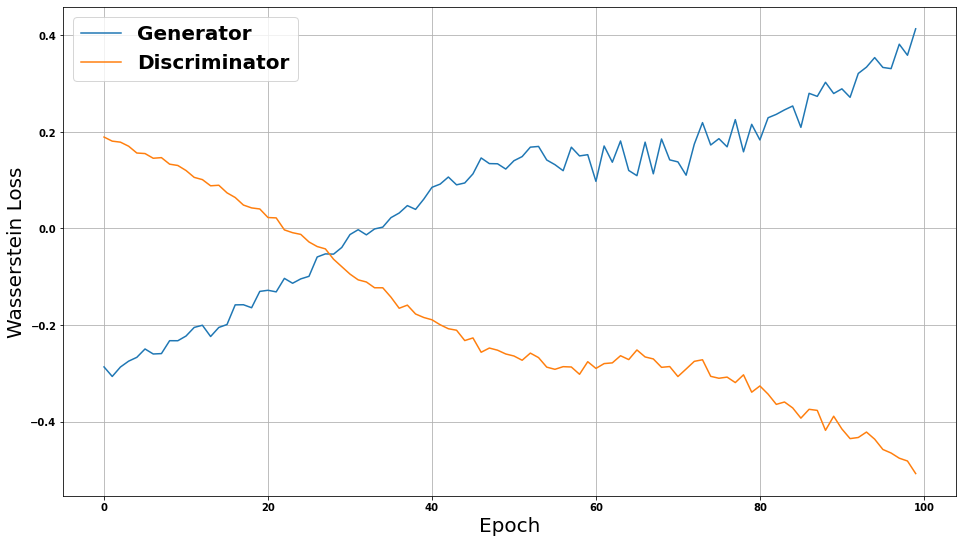

In [39]:
qwgan.train(x_train_sig)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

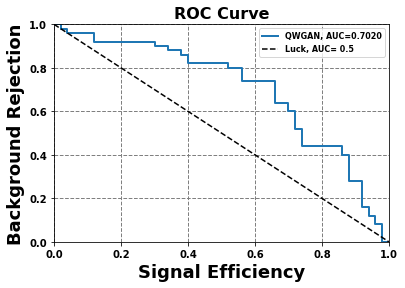

In [41]:
qwgan.test(x_test, y_test)

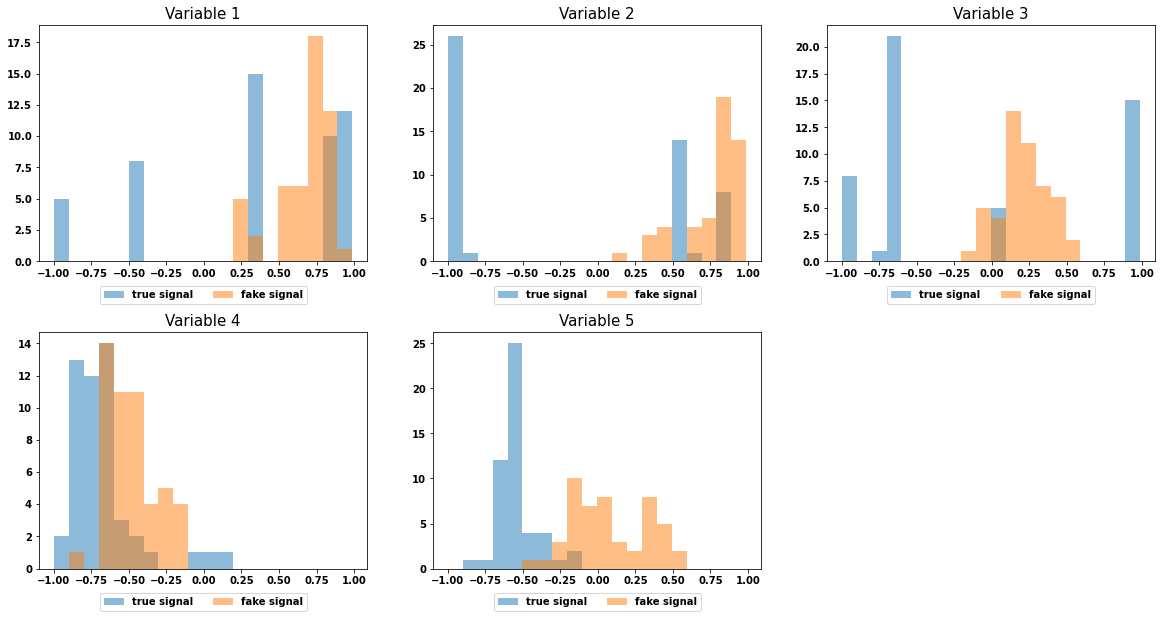

In [42]:
samples = qwgan.generate_samples(batch_size=50).numpy()
make_plots([x_train_sig, samples], ['true signal', 'fake signal'])